In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../.."))
from utils.FeatureEngineeringFunctions import PrepareTest, loadData

In [55]:
data_types = {
    "Store": "int16",
    "DayOfWeek": "int8",
    "CompetitionDistance": "float32",
    "CompetitionOpenSinceMonth": "float32",
    "CompetitionOpenSinceYear": "float32",
    "CompetitionDistanceMissing": "bool",
    "CompetitionOpenMissing": "bool",
    "StateHoliday": "category",
    "SchoolHoliday": "int8",
    "Promo": "bool",
    "Promo2": "bool",
    "Promo2SinceYear": "float32",
    "Promo2SinceWeek": "float32",
    "PromoInterval": "category",
    "StoreType": "category",
    "Assortment": "category",
    "Sales": "float32"
}

In [ ]:
data = pd.read_csv(
    "../../Data/intermediate/cleaned_training_data.csv",
    dtype = data_types,
    parse_dates=["Date"],
    index_col="Date_index",
    encoding="utf-8",
)

In [41]:
# another version
data = loadData("train")

In [4]:
data.head()

,Store,Date,DayOfWeek,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionDistanceMissing,CompetitionOpenMissing,StateHoliday,SchoolHoliday,Promo,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,StoreType,Assortment,Sales
Date_index,,,,,,,,,,,,,,,,,,
2015-07-31,1,2015-07-31,5,1270.0,9.0,2008.0,False,False,0,1,True,False,0.0,0.0,no_promo,c,a,8.568457
2015-07-31,2,2015-07-31,5,570.0,11.0,2007.0,False,False,0,1,True,True,2010.0,13.0,"Jan,Apr,Jul,Oct",a,a,8.710125
2015-07-31,3,2015-07-31,5,14130.0,12.0,2006.0,False,False,0,1,True,True,2011.0,14.0,"Jan,Apr,Jul,Oct",a,a,9.025696
2015-07-31,4,2015-07-31,5,620.0,9.0,2009.0,False,False,0,1,True,False,0.0,0.0,no_promo,c,c,9.546455
2015-07-31,5,2015-07-31,5,29910.0,4.0,2015.0,False,False,0,1,True,False,0.0,0.0,no_promo,a,a,8.480944


In [5]:
data.PromoInterval.isna().sum()

np.int64(0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

## Working on Date column
I will extract year month and day cuz most models can't understand Timestamp as it is

In [4]:
def TransformDateFeature_(data):
    """Extracts date features from the 'Date' column in the DataFrame."""
    data["Year"] = data["Date"].dt.year.astype(np.int16)
    data["Month"] = data["Date"].dt.month.astype(np.int8)
    data["Day"] = data["Date"].dt.day.astype(np.int8)

    # Sales often spike at the beginning and end of the month.
    # This flag captures the last few days of the month.
    
    data["DayOfYear"] = data["Date"].dt.dayofyear.astype(np.int16)
    data["WeekOfYear"] = data["Date"].dt.isocalendar().week.astype(np.int8)
    data["IsLastDayOfMonth"] = data["Date"].dt.is_month_end.astype(bool)

    # 1. Cyclical Encoding for DayOfWeek -- it's important to capture the cyclical nature of days in a week
    # NN may misinterpret Monday (1) and Sunday (7) as being far apart numerically the same as 1-12 for months
    data["DayOfWeek_sin"] = np.sin(2 * np.pi * data["DayOfWeek"] / 7).astype(np.float32)
    data["DayOfWeek_cos"] = np.cos(2 * np.pi * data["DayOfWeek"] / 7).astype(np.float32)
    data["Month_sin"] = np.sin(2 * np.pi * data["Month"] / 12).astype(np.float32)
    data["Month_cos"] = np.cos(2 * np.pi * data["Month"] / 12).astype(np.float32)

    data["IsWeekend"] = data["DayOfWeek"].isin([6, 7]).astype(bool)
    data["IsMonthEnd"] = data["Date"].dt.is_month_end.astype(bool)
    data["IsMonthStart"] = data["Date"].dt.is_month_start.astype(bool)
    return data

In [61]:
# data = TransformDateFeature(data)
# data.head()

In [7]:
pd.set_option('display.max_columns', None)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

### Work on competition columns

In [64]:
data.CompetitionDistanceMissing.value_counts()

CompetitionDistanceMissing
False    842152
True       2186
Name: count, dtype: int64

In [65]:
comp = data[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
'CompetitionDistanceMissing',
'CompetitionOpenMissing']]
comp['Sales'] = np.expm1(data['Sales'])
# data of sales but taking exponential to reverse log1p

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13248\3638629749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp['Sales'] = np.expm1(data['Sales'])


In [66]:
comp.describe()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Sales
count,842152.000000,844338.000000,844338.000000,844338.000000
mean,5458.158203,5.244601,2004.340698,6954.958496
std,7809.573242,3.928361,8.066525,3103.815674
min,20.000000,1.000000,1900.000000,45.000000
25%,710.000000,1.000000,1995.000000,4858.001953
50%,2320.000000,4.000000,2006.000000,6368.002930
75%,6890.000000,9.000000,2011.000000,8359.000000
max,75860.000000,12.000000,2015.000000,41550.003906


In [67]:
# label high middle low for competition distance
comp['CompetitionDistanceLevel'] = pd.cut(
    comp['CompetitionDistance'],
    bins=[
        -1,
        comp['CompetitionDistance'].quantile(0.25),
        comp['CompetitionDistance'].quantile(0.5),
        comp['CompetitionDistance'].quantile(0.75),
        np.inf
    ],
    labels=['Near', 'Medium', 'Far', 'Very Far']
).astype('category')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13248\2282691874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp['CompetitionDistanceLevel'] = pd.cut(


In [68]:
comp.groupby("CompetitionDistanceLevel", observed=True)["Sales"].agg(['sum', 'mean', 'median'])

,sum,mean,median
CompetitionDistanceLevel,,,
Near,1.555830e+09,7356.065918,6586.999512
Medium,1.452503e+09,6929.915039,6208.000000
Far,1.416039e+09,6711.976074,6311.999512
Very Far,1.435982e+09,6835.472656,6393.997559


In [69]:
comp.head()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionDistanceMissing,CompetitionOpenMissing,Sales,CompetitionDistanceLevel
Date_index,,,,,,,
2015-07-31,1270.0,9.0,2008.0,False,False,5262.000977,Medium
2015-07-31,570.0,11.0,2007.0,False,False,6063.000488,Near
2015-07-31,14130.0,12.0,2006.0,False,False,8312.997070,Very Far
2015-07-31,620.0,9.0,2009.0,False,False,13994.000000,Near
2015-07-31,29910.0,4.0,2015.0,False,False,4820.998047,Very Far


In [70]:
comp = comp.copy()
comp["OpenDate"] = pd.to_datetime(
    comp["CompetitionOpenSinceYear"].astype(int).astype(str)+ "-"+ comp["CompetitionOpenSinceMonth"].astype(int).astype(str)+ "-01",
    errors="coerce",
)

In [71]:
comp.OpenDate.head()

Date_index
2015-07-31   2008-09-01
2015-07-31   2007-11-01
2015-07-31   2006-12-01
2015-07-31   2009-09-01
2015-07-31   2015-04-01
Name: OpenDate, dtype: datetime64[ns]

In [72]:
comp["OpenDuration"] = (
    (data["Date"].dt.year - comp["OpenDate"].dt.year) * 12
    + (data["Date"].dt.month - comp["OpenDate"].dt.month)
).astype("int16")
comp.OpenDuration.head()

Date_index
2015-07-31     82
2015-07-31     92
2015-07-31    103
2015-07-31     70
2015-07-31      3
Name: OpenDuration, dtype: int16

In [73]:
comp.OpenDuration.describe()

count    844338.000000
mean        114.501672
std          99.448294
min         -31.000000
25%          29.000000
50%          91.000000
75%         223.000000
max        1386.000000
Name: OpenDuration, dtype: float64

In [74]:
comp.OpenDuration.quantile(0.995)

np.float64(278.0)

In [75]:
comp[comp.OpenDuration < 0].shape[0]

70101

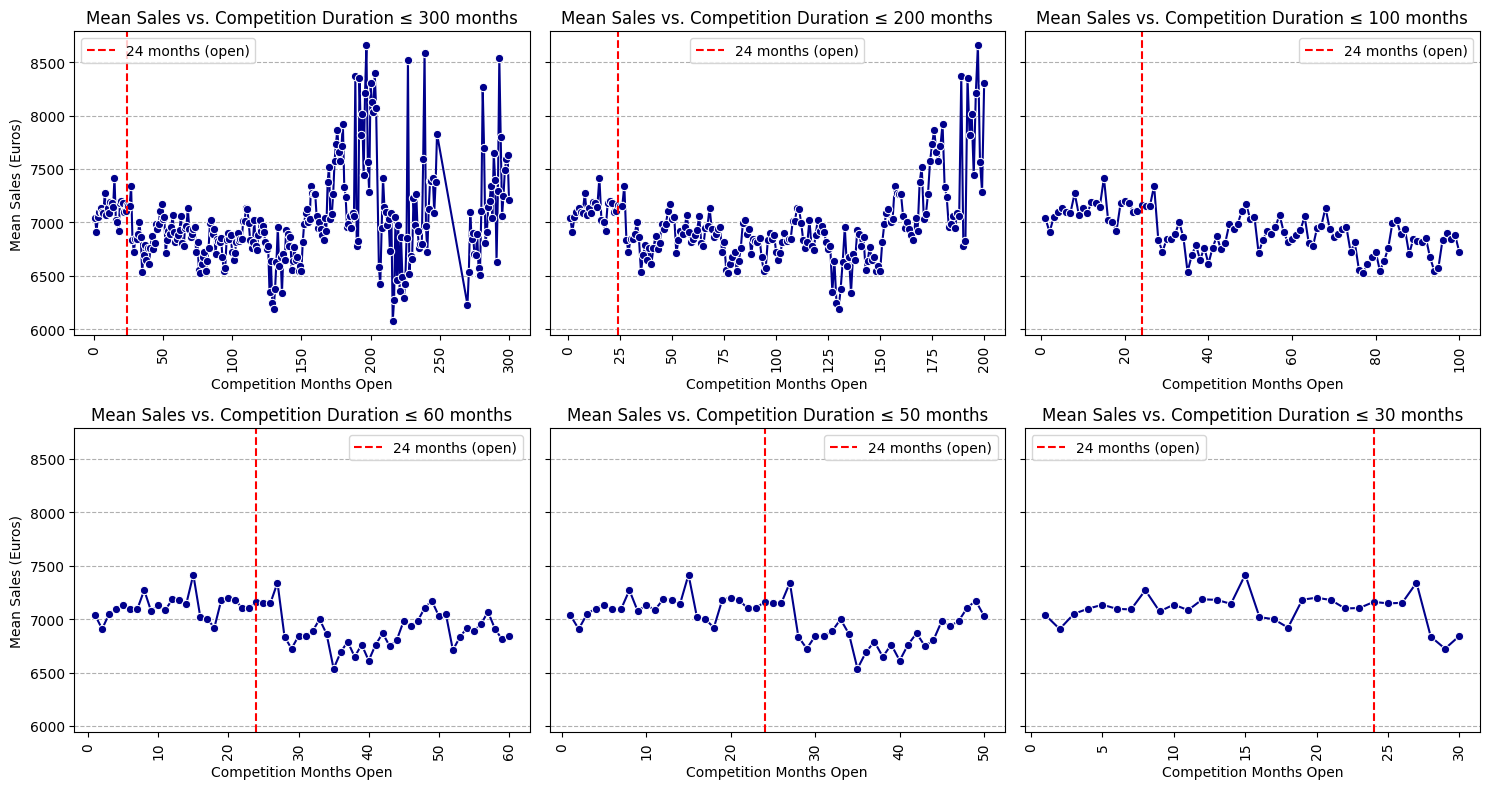

In [76]:
# comp['OpenDurationYears'] = (comp['OpenDuration'] / 12).apply(np.floor).astype('int8')

sales_by_duration = comp.groupby("OpenDuration")["Sales"].mean().reset_index()

caps = [300, 200, 100, 60, 50, 30]

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for ax, cap in zip(axes, caps):
    df = sales_by_duration[(sales_by_duration["OpenDuration"] <= cap) & (sales_by_duration["OpenDuration"] > 0)].copy()

    sns.lineplot(
        data=df,
        x="OpenDuration",
        y="Sales",
        marker="o",
        color="darkblue",
        ax=ax,
    )
    ax.set_title(f"Mean Sales vs. Competition Duration ≤ {cap} months")
    
    # ticks = np.arange(df["OpenDuration"].min(), cap + 1, 10)
    # ax.set_xticks(ticks)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel("Competition Months Open")
    ax.set_ylabel("Mean Sales (Euros)")
    ax.axvline(x=24, color="red", linestyle="--", label="24 months (open)")
    ax.legend()
    ax.grid(axis="y", linestyle="--")

plt.tight_layout()
plt.show()

In [77]:
comp["OpenDuration"] = comp["OpenDuration"].apply(
    lambda x: 24 if x > 24 else (0 if x < 0 else x))

In [78]:
# comp["OpenDurationYears"] = (comp["OpenDuration"] / 12).apply(np.floor).astype("int8")

# sales_by_duration = comp.groupby("OpenDurationYears")["Sales"].mean().reset_index()

# caps = [25, 20, 15, 10, 5, 3]

# fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
# axes = axes.flatten()

# for ax, cap in zip(axes, caps):
#     df = sales_by_duration[
#         (sales_by_duration["OpenDurationYears"] <= cap)
#         & (sales_by_duration["OpenDurationYears"] > 0)
#     ].copy()

#     sns.lineplot(
#         data=df,
#         x="OpenDurationYears",
#         y="Sales",
#         marker="o",
#         color="darkblue",
#         ax=ax,
#     )
#     ax.set_title(f"Mean Sales vs. Competition Duration ≤ {cap} years", c = 'red', fontweight='bold')

#     # ticks = np.arange(df["OpenDurationYears"].min(), cap + 1, 10)
#     # ax.set_xticks(ticks)
#     ax.tick_params(axis="x", rotation=90)
#     ax.set_xlabel("Competition Years Open")
#     ax.set_ylabel("Mean Sales (Euros)")
#     # ax.axvline(x=0, color="red", linestyle="--", label="0 months (open)")
#     ax.legend()
#     ax.grid(axis="y", linestyle="--")

# plt.tight_layout()
# plt.show()

In [79]:
del comp

In [7]:
def feature_competition_duration_(data):
    # Create a synthetic Date for when the competition opened
    
    data["OpenDate"] = pd.to_datetime(
        data["CompetitionOpenSinceYear"].astype(int).astype(str)
        + "-"
        + data["CompetitionOpenSinceMonth"].astype(int).astype(str)
        + "-01",
        errors="coerce",
    )

    # 2. Calculate "Months Since Open"
    # (Current Date - Open Date) / 30 days
    data["OpenDuration"] = (
    (data["Date"].dt.year - data["OpenDate"].dt.year) * 12
    + (data["Date"].dt.month - data["OpenDate"].dt.month)).astype(np.int8)

    # Consider only last 24 months of competition impact, taking in consideration that we will predict only next 6 months
    # So we only need to know if competition has been open for more than 24 months and it's effect on sales
    # We don't have to generalize beyond that for our prediction horizon
    # If opened > 24 months ago, cap it. If opened in future (negative), set to 0.
    
    data["OpenDuration"] = data["OpenDuration"].apply(
        lambda x: 24 if x > 24 else (0 if x < 0 else x)
    ).astype(np.int8)

    # Clean up intermediate column
    data.drop(columns=["OpenDate", 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], axis=1, inplace=True)
    return data

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

In [ ]:
# data = TransformDateFeature_(data)
# data = feature_competition_duration_(data)
# data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   DayOfWeek                   844338 non-null  int8    
 2   CompetitionDistance         842152 non-null  float32 
 3   CompetitionDistanceMissing  844338 non-null  bool    
 4   CompetitionOpenMissing      844338 non-null  bool    
 5   StateHoliday                844338 non-null  category
 6   SchoolHoliday               844338 non-null  int8    
 7   Promo                       844338 non-null  bool    
 8   Promo2                      844338 non-null  bool    
 9   Promo2SinceYear             844338 non-null  float32 
 10  Promo2SinceWeek             844338 non-null  float32 
 11  PromoInterval               844338 non-null  category
 12  StoreType                   844338 non-null  categ

In [ ]:
# test = loadAndPrepareTest("../Data/intermediate/merged_testing_data.csv")
# test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Store                       41088 non-null  int16         
 1   DayOfWeek                   41088 non-null  int8          
 2   Date                        41088 non-null  datetime64[ns]
 3   Promo                       41088 non-null  bool          
 4   StateHoliday                41088 non-null  category      
 5   SchoolHoliday               41088 non-null  int8          
 6   StoreType                   41088 non-null  category      
 7   Assortment                  41088 non-null  category      
 8   CompetitionDistance         40992 non-null  float32       
 9   Promo2                      41088 non-null  bool          
 10  CompetitionDistanceMissing  41088 non-null  bool          
 11  CompetitionOpenMissing      41088 non-null  bool      

#### Working on promo columns

In [84]:
promo = data[['Promo', 'Promo2','Promo2SinceYear','Promo2SinceWeek','PromoInterval', 'Year', 'Month', 'WeekOfYear']].copy()

In [85]:
promo.head()

,Promo,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Year,Month,WeekOfYear
Date_index,,,,,,,,
2015-07-31,True,False,0.0,0.0,no_promo,2015,7,31
2015-07-31,True,True,2010.0,13.0,"Jan,Apr,Jul,Oct",2015,7,31
2015-07-31,True,True,2011.0,14.0,"Jan,Apr,Jul,Oct",2015,7,31
2015-07-31,True,False,0.0,0.0,no_promo,2015,7,31
2015-07-31,True,False,0.0,0.0,no_promo,2015,7,31


In [86]:
data.head()

,Store,Date,DayOfWeek,CompetitionDistance,CompetitionDistanceMissing,CompetitionOpenMissing,StateHoliday,SchoolHoliday,Promo,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,StoreType,Assortment,Sales,Year,Month,Day,DayOfYear,WeekOfYear,IsLastDayOfMonth,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,IsWeekend,IsMonthEnd,IsMonthStart,OpenDuration
Date_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,2015-07-31,5,1270.0,False,False,0,1,True,False,0.0,0.0,no_promo,c,a,8.568457,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24
2015-07-31,2,2015-07-31,5,570.0,False,False,0,1,True,True,2010.0,13.0,"Jan,Apr,Jul,Oct",a,a,8.710125,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24
2015-07-31,3,2015-07-31,5,14130.0,False,False,0,1,True,True,2011.0,14.0,"Jan,Apr,Jul,Oct",a,a,9.025696,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24
2015-07-31,4,2015-07-31,5,620.0,False,False,0,1,True,False,0.0,0.0,no_promo,c,c,9.546455,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24
2015-07-31,5,2015-07-31,5,29910.0,False,False,0,1,True,False,0.0,0.0,no_promo,a,a,8.480944,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,3


In [87]:
print(promo.Promo.shape[0])
promo.Promo.value_counts()

844338


Promo
False    467463
True     376875
Name: count, dtype: int64

In [88]:
promo.Promo2.value_counts()

Promo2
False    423292
True     421046
Name: count, dtype: int64

In [89]:
promo.Promo2SinceYear.value_counts()

Promo2SinceYear
0.0       423292
2011.0     95035
2013.0     91854
2014.0     65757
2012.0     60712
2009.0     53824
2010.0     46412
2015.0      7452
Name: count, dtype: int64

In [90]:
promo.Promo2SinceWeek.value_counts()

Promo2SinceWeek
0.0     423292
14.0     60535
40.0     51507
31.0     33235
10.0     32204
5.0      29721
37.0     27115
1.0      26869
13.0     24577
45.0     24071
22.0     23643
18.0     22452
35.0     18888
9.0      10293
27.0      7924
36.0      7619
48.0      7033
39.0      3889
23.0      3558
44.0      2182
26.0       782
50.0       780
28.0       779
6.0        768
49.0       622
Name: count, dtype: int64

In [91]:
print(promo.shape)
print(promo['Promo2SinceYear'].isna().sum())
print(promo['Promo2SinceWeek'].isna().sum())

(844338, 8)
0
0


In [92]:
data[data["Promo2SinceYear"] > 0][["Year", "Promo2SinceYear"]].head(10)

,Year,Promo2SinceYear
Date_index,,
2015-07-31,2015,2010.0
2015-07-31,2015,2011.0
2015-07-31,2015,2012.0
2015-07-31,2015,2010.0
2015-07-31,2015,2009.0
2015-07-31,2015,2011.0
2015-07-31,2015,2011.0
2015-07-31,2015,2010.0
2015-07-31,2015,2012.0


In [93]:
data[data["Year"] < data['Promo2SinceYear']][["Year", "Promo2SinceYear"]].shape[0]

34349

In [94]:
data[data["Year"] < data["Promo2SinceYear"]][["Year", "Promo2SinceYear"]].head()

,Year,Promo2SinceYear
Date_index,,
2014-12-31,2014,2015.0
2014-12-31,2014,2015.0
2014-12-31,2014,2015.0
2014-12-31,2014,2015.0
2014-12-31,2014,2015.0


In [95]:
promo.PromoInterval.value_counts()

PromoInterval
no_promo            423292
Jan,Apr,Jul,Oct     242397
Feb,May,Aug,Nov      97998
Mar,Jun,Sept,Dec     80651
Name: count, dtype: int64

In [96]:
data.columns

Index(['Store', 'Date', 'DayOfWeek', 'CompetitionDistance',
       'CompetitionDistanceMissing', 'CompetitionOpenMissing', 'StateHoliday',
       'SchoolHoliday', 'Promo', 'Promo2', 'Promo2SinceYear',
       'Promo2SinceWeek', 'PromoInterval', 'StoreType', 'Assortment', 'Sales',
       'Year', 'Month', 'Day', 'DayOfYear', 'WeekOfYear', 'IsLastDayOfMonth',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'IsWeekend',
       'IsMonthEnd', 'IsMonthStart', 'OpenDuration'],
      dtype='object')

In [6]:
def feature_engineer_promo2_(df):
    """
    Creates Promo2 new features: duration, start seasonality,
    and the "Is Active" flag, relying on numerical math instead of date conversion.
    """

    df["Promo2WeeksDuration"] = (df["Year"] - df["Promo2SinceYear"]) * 52 + (
        df["WeekOfYear"] - df["Promo2SinceWeek"])
    df["Promo2WeeksDuration"] = df["Promo2WeeksDuration"].clip(lower=0, upper=25).astype(np.int8)


    df.loc[df["Promo2"] == 0, "Promo2WeeksDuration"] = 0
    df["Promo2SinceMonth"] = (np.ceil(df["Promo2SinceWeek"] / 4.0)).astype(np.int8)

    # df.loc[df["Promo2"] == 0, "Promo2SinceMonth"] = 0


    month_to_str = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    df["MonthStr"] = df["Month"].map(month_to_str)

    def check_promo_active(row): 
        if row["Promo2"] == 1 and row["MonthStr"] in row["PromoInterval"]:
            return 1
        return 0

    df["IsPromo2Month"] = df.apply(check_promo_active, axis=1).astype(np.bool)
    

    df.drop(["Promo2SinceYear", "Promo2SinceWeek", "PromoInterval", "MonthStr"],axis=1,inplace=True)

    return df

In [15]:
df = feature_engineer_promo2_(data.copy())
df.head()

,Store,DayOfWeek,CompetitionDistance,CompetitionDistanceMissing,CompetitionOpenMissing,StateHoliday,SchoolHoliday,Promo,Promo2,StoreType,Assortment,Sales,Year,Month,Day,DayOfYear,WeekOfYear,IsLastDayOfMonth,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,IsWeekend,IsMonthEnd,IsMonthStart,OpenDuration,Promo2WeeksDuration,Promo2SinceMonth,IsPromo2Month
Date_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,1270.0,False,False,0,1,True,False,c,a,8.568457,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24,0,0,False
2015-07-31,2,5,570.0,False,False,0,1,True,True,a,a,8.710125,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24,25,4,True
2015-07-31,3,5,14130.0,False,False,0,1,True,True,a,a,9.025696,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24,25,4,True
2015-07-31,4,5,620.0,False,False,0,1,True,False,c,c,9.546455,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,24,0,0,False
2015-07-31,5,5,29910.0,False,False,0,1,True,False,a,a,8.480944,2015,7,31,212,31,True,-0.974928,-0.222521,-0.5,-0.866025,False,True,False,3,0,0,False


In [99]:
df.columns

Index(['Store', 'Date', 'DayOfWeek', 'CompetitionDistance',
       'CompetitionDistanceMissing', 'CompetitionOpenMissing', 'StateHoliday',
       'SchoolHoliday', 'Promo', 'Promo2', 'StoreType', 'Assortment', 'Sales',
       'Year', 'Month', 'Day', 'DayOfYear', 'WeekOfYear', 'IsLastDayOfMonth',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'IsWeekend',
       'IsMonthEnd', 'IsMonthStart', 'OpenDuration', 'Promo2WeeksDuration',
       'Promo2SinceMonth', 'IsPromo2Month'],
      dtype='object')

In [100]:
df.describe()

,Store,Date,DayOfWeek,CompetitionDistance,SchoolHoliday,Sales,Year,Month,Day,DayOfYear,WeekOfYear,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,OpenDuration,Promo2WeeksDuration,Promo2SinceMonth
count,844338.000000,844338,844338.000000,842152.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,8.443380e+05,8.443380e+05,844338.000000,844338.000000,844338.000000
mean,558.421374,2014-04-11 01:08:38.729702912,3.520350,5458.158203,0.193578,8.757562,2013.831945,5.845774,15.835706,162.387649,23.646946,0.003880,-0.157365,1.129590e-01,-6.831077e-02,20.247731,10.333509,3.129879
min,1.000000,2013-01-01 00:00:00,1.000000,20.000000,0.000000,3.828641,2013.000000,1.000000,1.000000,1.000000,1.000000,-0.974928,-0.900969,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000
25%,280.000000,2013-08-16 00:00:00,2.000000,710.000000,0.000000,8.488588,2013.000000,3.000000,8.000000,75.000000,11.000000,-0.781832,-0.900969,-5.000000e-01,-8.660254e-01,24.000000,0.000000,0.000000
50%,558.000000,2014-03-31 00:00:00,3.000000,2320.000000,0.000000,8.759198,2014.000000,6.000000,16.000000,154.000000,23.000000,0.433884,-0.222521,1.224647e-16,-1.836970e-16,24.000000,0.000000,0.000000
75%,837.000000,2014-12-11 00:00:00,5.000000,6890.000000,0.000000,9.031214,2014.000000,8.000000,23.000000,241.000000,35.000000,0.781832,0.623490,8.660254e-01,5.000000e-01,24.000000,25.000000,6.000000
max,1115.000000,2015-07-31 00:00:00,7.000000,75860.000000,1.000000,10.634677,2015.000000,12.000000,31.000000,365.000000,52.000000,0.974928,1.000000,1.000000e+00,1.000000e+00,24.000000,25.000000,13.000000
std,321.730861,NaN,1.723712,7809.573242,0.395102,0.425278,0.777271,3.323959,8.683392,101.368955,14.389931,0.763957,0.625773,6.931140e-01,7.086381e-01,7.902189,12.160586,3.943775


In [101]:
dfixtypes = data[['DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']].copy()
dfixtypes.describe()

,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos
count,844338.000000,844338.000000,8.443380e+05,8.443380e+05
mean,0.003880,-0.157365,1.129590e-01,-6.831077e-02
std,0.763957,0.625773,6.931140e-01,7.086381e-01
min,-0.974928,-0.900969,-1.000000e+00,-1.000000e+00
25%,-0.781832,-0.900969,-5.000000e-01,-8.660254e-01
50%,0.433884,-0.222521,1.224647e-16,-1.836970e-16
75%,0.781832,0.623490,8.660254e-01,5.000000e-01
max,0.974928,1.000000,1.000000e+00,1.000000e+00


In [102]:
dfixtypes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   DayOfWeek_sin  844338 non-null  float32
 1   DayOfWeek_cos  844338 non-null  float32
 2   Month_sin      844338 non-null  float32
 3   Month_cos      844338 non-null  float32
dtypes: float32(4)
memory usage: 51.6+ MB


In [103]:
del dfixtypes, df, promo

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionDistanceMissing  844338 non-null  bool          
 5   CompetitionOpenMissing      844338 non-null  bool          
 6   StateHoliday                844338 non-null  category      
 7   SchoolHoliday               844338 non-null  int8          
 8   Promo                       844338 non-null  bool          
 9   Promo2                      844338 non-null  bool          
 10  Promo2SinceYear             844338 non-null  float32       
 11  Promo2SinceWeek             844

### Apply Transformation on training data 1

In [ ]:
# data = TransformDateFeature_(data)
# data = feature_competition_duration_(data)
# data = feature_engineer_promo2_(data)
# data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   DayOfWeek                   844338 non-null  int8    
 2   CompetitionDistance         842152 non-null  float32 
 3   CompetitionDistanceMissing  844338 non-null  bool    
 4   CompetitionOpenMissing      844338 non-null  bool    
 5   StateHoliday                844338 non-null  category
 6   SchoolHoliday               844338 non-null  int8    
 7   Promo                       844338 non-null  bool    
 8   Promo2                      844338 non-null  bool    
 9   StoreType                   844338 non-null  category
 10  Assortment                  844338 non-null  category
 11  Sales                       844338 non-null  float32 
 12  Year                        844338 non-null  int32

### Working on Holiday's columns and it's effects

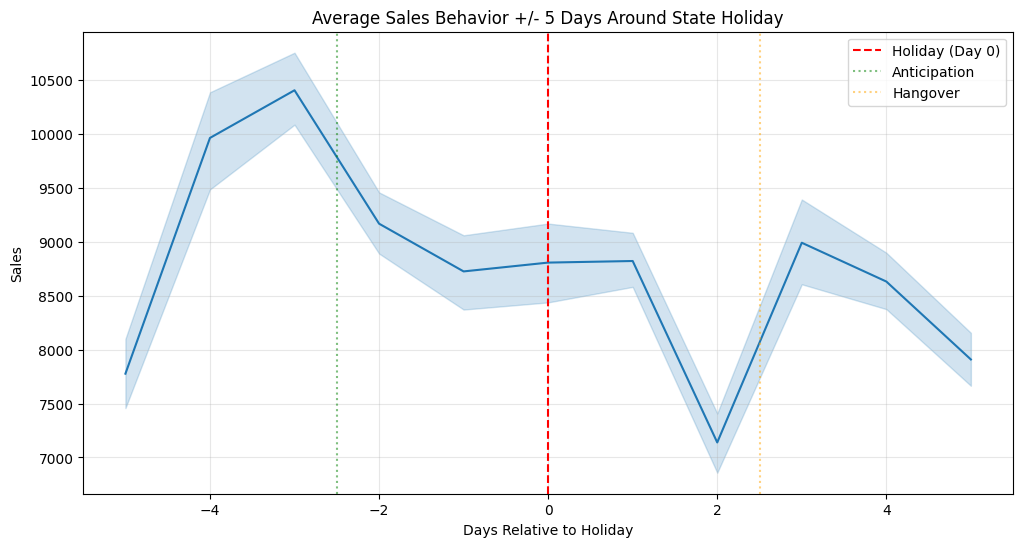

In [ ]:
window = 7
df = data.copy()
df['Sales'] = np.expm1(df.Sales)
"""
aligns sales df around State Holidays to visualize the
'Anticipation' and 'Hangover' effects.
"""

df["StateHoliday"] = df["StateHoliday"].astype(str)
holiday_dates = df[df["StateHoliday"] != "0"][["Date", "Store"]]

aligned_df = []
sample_stores = df["Store"].unique()

for store_id in sample_stores:
    store_df = (
        df[df["Store"] == store_id].sort_values("Date").set_index("Date")
    )
    holidays = holiday_dates[holiday_dates["Store"] == store_id]["Date"]

    for h_date in holidays:
        start_date = h_date - pd.Timedelta(days=window)
        end_date = h_date + pd.Timedelta(days=window)

        # Slice the df
        mask = (store_df.index >= start_date) & (store_df.index <= end_date)
        window_df = store_df[mask].copy()

        if len(window_df) > 0:
            # Calculate "Days Relative to Holiday"
            window_df["DaysRelative"] = (window_df.index - h_date).days
            aligned_df.append(window_df[["DaysRelative", "Sales"]])

plot_df = pd.concat(aligned_df)

plt.figure(figsize=(12, 6))

sns.lineplot(data=plot_df, x="DaysRelative", y="Sales", errorbar="ci")

# Add markers for context
plt.axvline(x=0, color="red", linestyle="--", label="Holiday (Day 0)")
plt.axvline(x=-2.5, color="green", linestyle=":", alpha=0.5, label="Anticipation")
plt.axvline(x=2.5, color="orange", linestyle=":", alpha=0.5, label="Hangover")

plt.title(f"Average Sales Behavior +/- {window} Days Around State Holiday")
plt.xlabel("Days Relative to Holiday")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



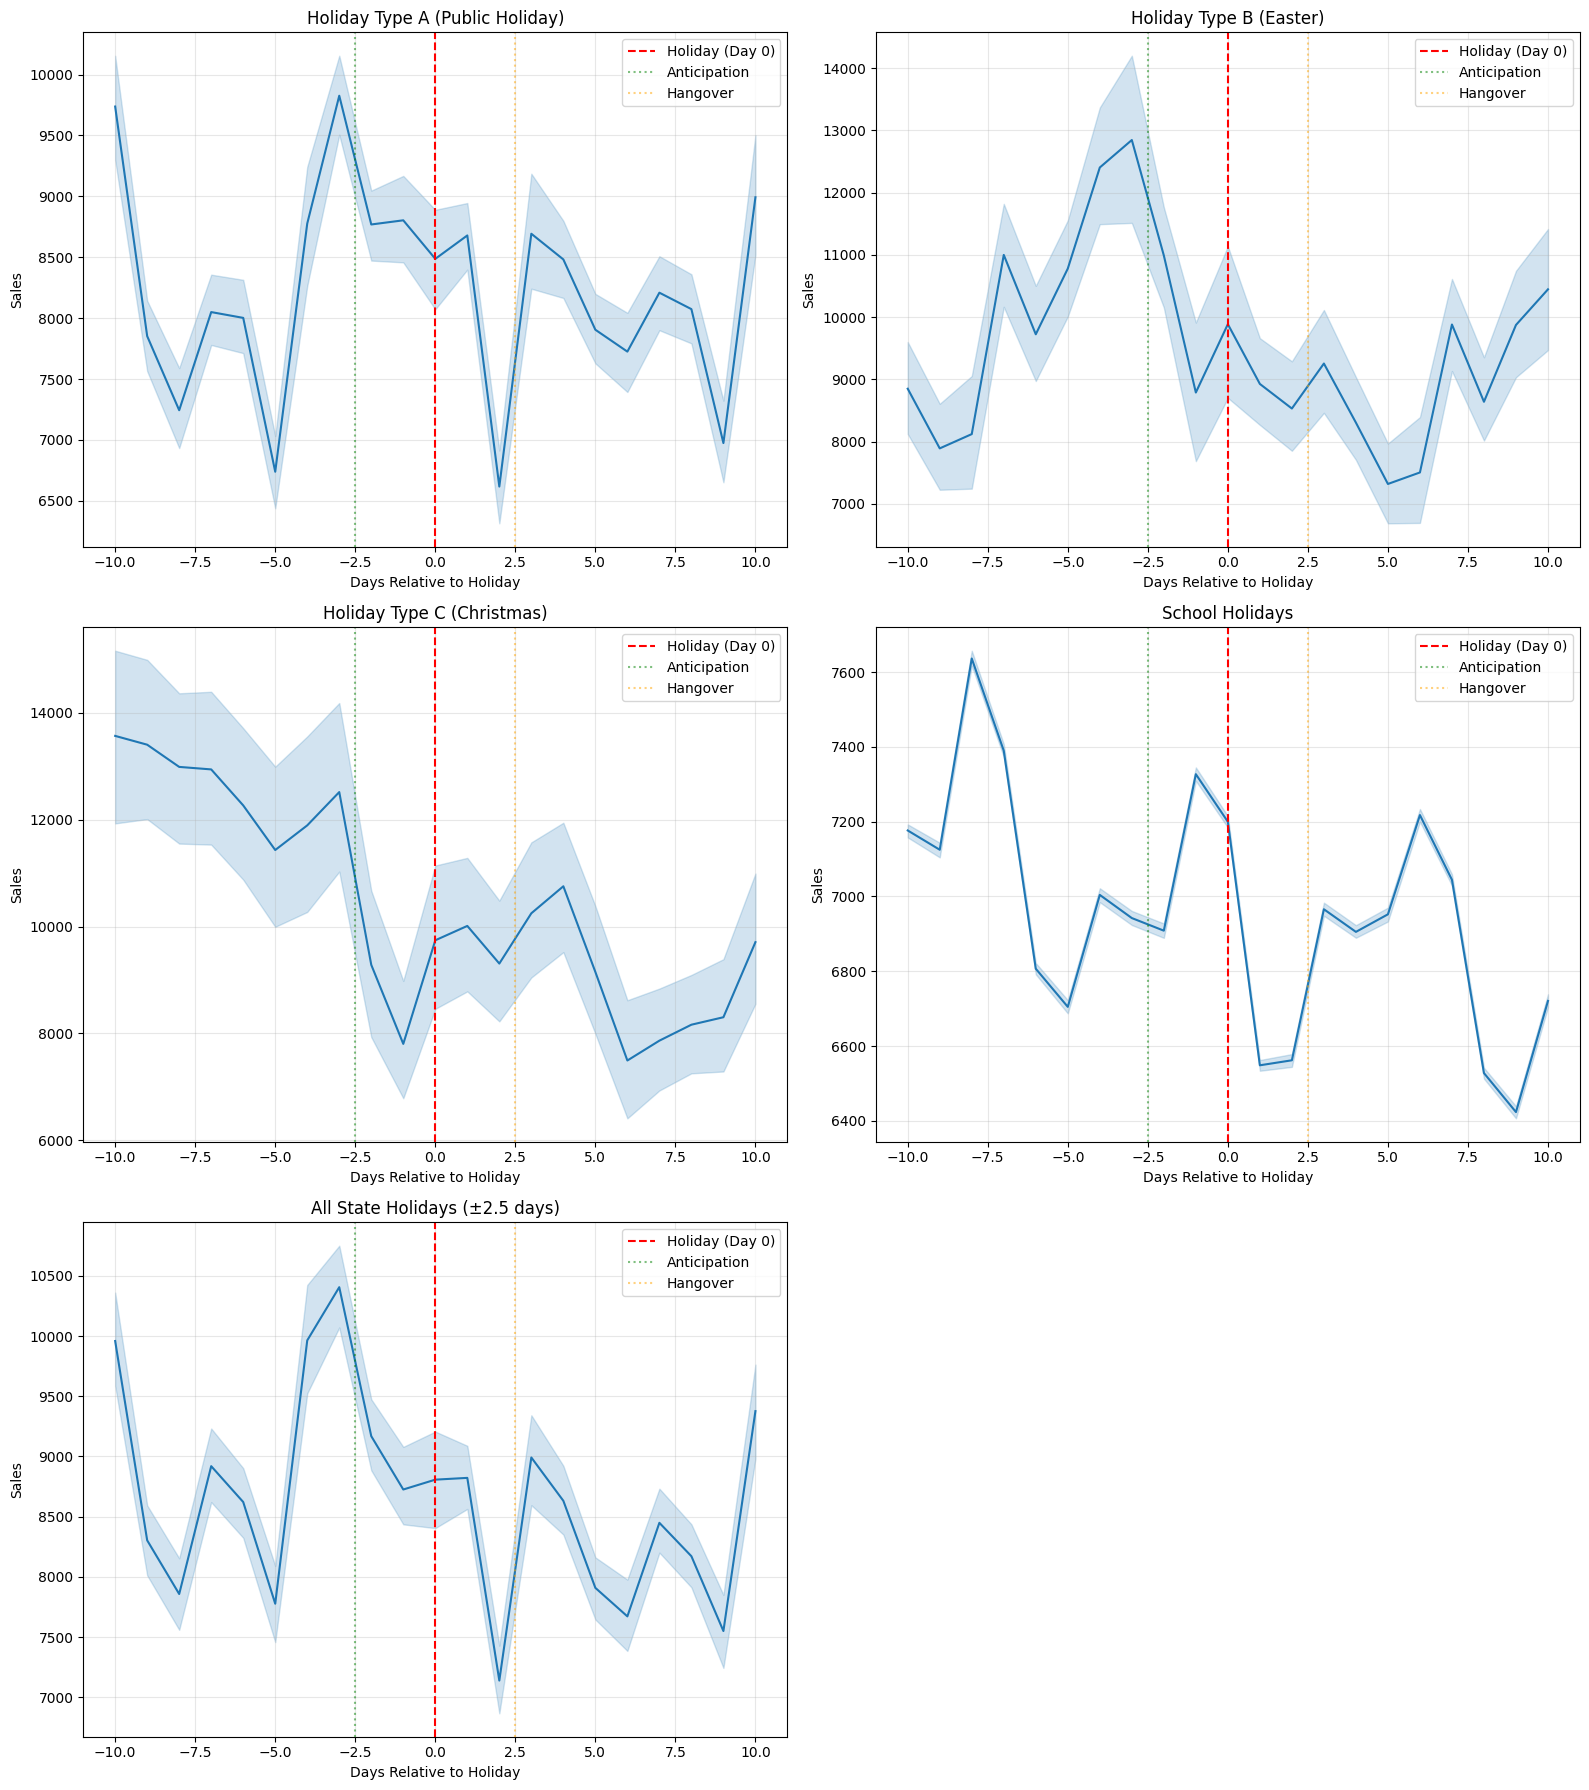

In [ ]:
window = 5
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Date"])
df["StateHoliday"] = df["StateHoliday"].astype(str)

def get_aligned(df, holiday_mask, window=5):
    aligned = []
    holiday_dates = df[holiday_mask][["Store", "Date"]]

    for store_id, group in df.groupby("Store"):
        store_df = group.set_index("Date")
        dates = holiday_dates[holiday_dates["Store"] == store_id]["Date"]

        for h_date in dates:
            start = h_date - pd.Timedelta(days=window)
            end = h_date + pd.Timedelta(days=window)
            sub = store_df.loc[start:end].copy()

            if len(sub) == 0:
                continue

            sub["DaysRelative"] = (sub.index - h_date).days
            aligned.append(sub[["DaysRelative", "Sales"]])

    if len(aligned) == 0:
        return pd.DataFrame(columns=["DaysRelative", "Sales"])

    return pd.concat(aligned)


aligned_a = get_aligned(df, df["StateHoliday"] == "a", window)
aligned_b = get_aligned(df, df["StateHoliday"] == "b", window)
aligned_c = get_aligned(df, df["StateHoliday"] == "c", window)
aligned_school = get_aligned(df, df["SchoolHoliday"] == 1, window)

aligned_all = get_aligned(df, df["StateHoliday"] != "0", window)

# ---------------------------
# PLOTTING: SUBPLOTS
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

titles = [
    ("Holiday Type A (Public Holiday)", aligned_a),
    ("Holiday Type B (Easter)", aligned_b),
    ("Holiday Type C (Christmas)", aligned_c),
    ("School Holidays", aligned_school),
    (f"All State Holidays (±{window} days)", aligned_all),
]

for i, (title, plot_df) in enumerate(titles):
    ax = axes[i]

    if len(plot_df) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=14)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        continue

    sns.lineplot(data=plot_df, x="DaysRelative", y="Sales", errorbar="ci", ax=ax)

    ax.axvline(0, color="red", linestyle="--", label="Holiday (Day 0)")
    ax.axvline(-2.5, color="green", linestyle=":", alpha=0.5, label="Anticipation")
    ax.axvline(2.5, color="orange", linestyle=":", alpha=0.5, label="Hangover")

    ax.set_title(title)
    ax.set_xlabel("Days Relative to Holiday")
    ax.set_ylabel("Sales")
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[-1].axis("off")

plt.tight_layout()
plt.show()

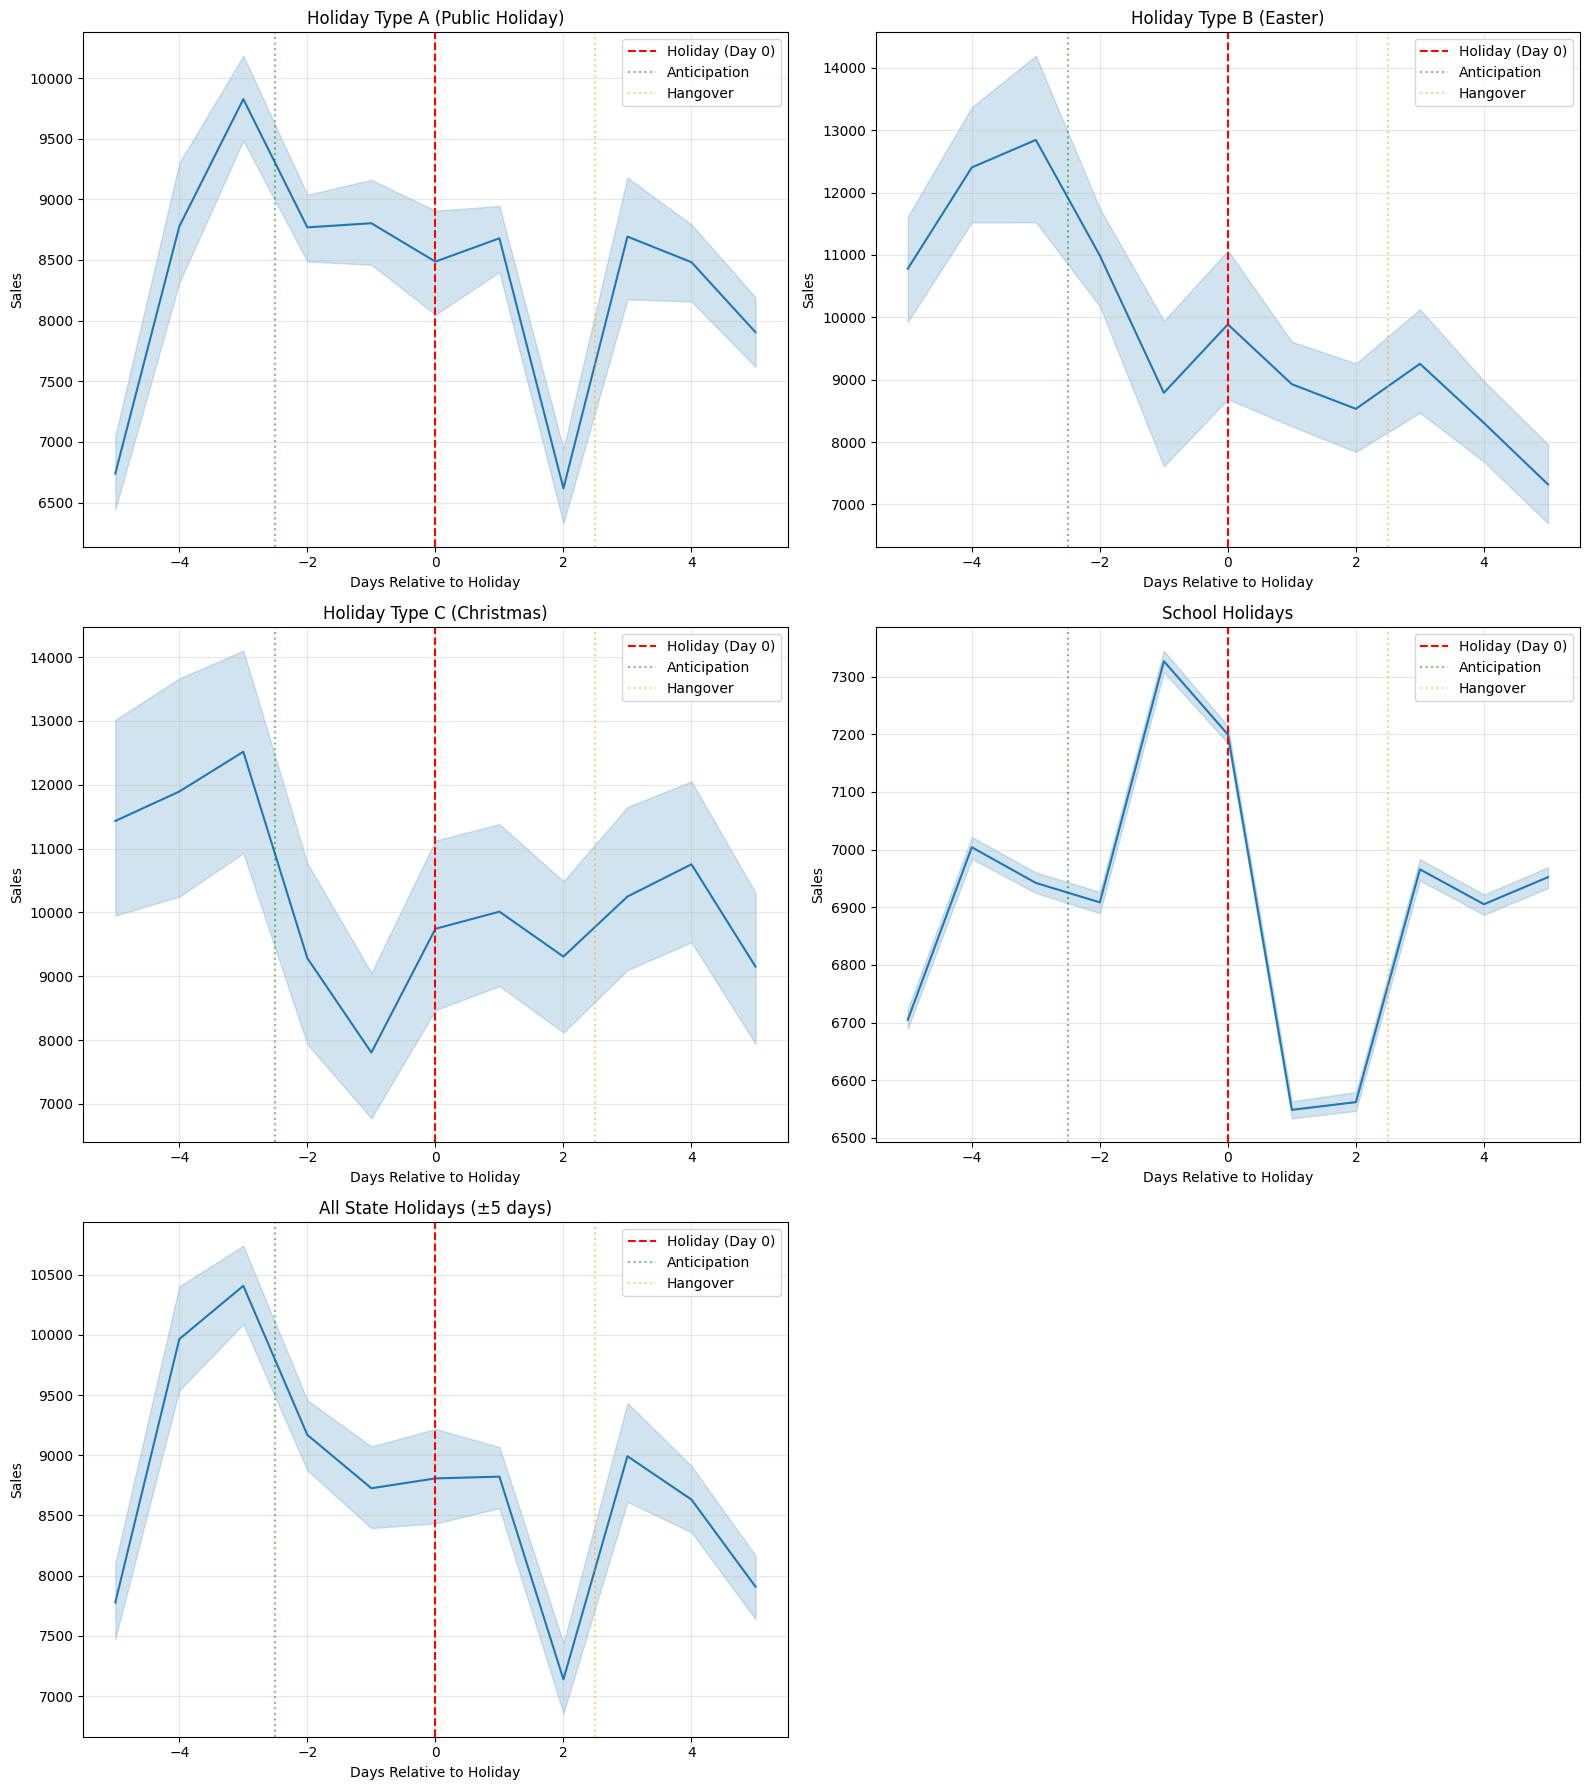

In [ ]:
window = 5
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Date"])
df["StateHoliday"] = df["StateHoliday"].astype(str)


def get_aligned(df, holiday_mask, window=5):
    aligned = []
    holiday_dates = df[holiday_mask][["Store", "Date"]]

    for store_id, group in df.groupby("Store"):
        store_df = group.set_index("Date")
        dates = holiday_dates[holiday_dates["Store"] == store_id]["Date"]

        for h_date in dates:
            start = h_date - pd.Timedelta(days=window)
            end = h_date + pd.Timedelta(days=window)
            sub = store_df.loc[start:end].copy()

            if len(sub) == 0:
                continue

            sub["DaysRelative"] = (sub.index - h_date).days
            aligned.append(sub[["DaysRelative", "Sales"]])

    if len(aligned) == 0:
        return pd.DataFrame(columns=["DaysRelative", "Sales"])

    return pd.concat(aligned)


aligned_a = get_aligned(df, df["StateHoliday"] == "a", window)
aligned_b = get_aligned(df, df["StateHoliday"] == "b", window)
aligned_c = get_aligned(df, df["StateHoliday"] == "c", window)
aligned_school = get_aligned(df, df["SchoolHoliday"] == 1, window)

aligned_all = get_aligned(df, df["StateHoliday"] != "0", window)

# ---------------------------
# PLOTTING: SUBPLOTS
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

titles = [
    ("Holiday Type A (Public Holiday)", aligned_a),
    ("Holiday Type B (Easter)", aligned_b),
    ("Holiday Type C (Christmas)", aligned_c),
    ("School Holidays", aligned_school),
    (f"All State Holidays (±{window} days)", aligned_all),
]

for i, (title, plot_df) in enumerate(titles):
    ax = axes[i]

    if len(plot_df) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=14)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        continue

    sns.lineplot(data=plot_df, x="DaysRelative", y="Sales", errorbar="ci", ax=ax)

    ax.axvline(0, color="red", linestyle="--", label="Holiday (Day 0)")
    ax.axvline(-2.5, color="green", linestyle=":", alpha=0.5, label="Anticipation")
    ax.axvline(2.5, color="orange", linestyle=":", alpha=0.5, label="Hangover")

    ax.set_title(title)
    ax.set_xlabel("Days Relative to Holiday")
    ax.set_ylabel("Sales")
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[-1].axis("off")

plt.tight_layout()
plt.show()

#### Some insights

You can see that peek of sales 1 2 or three days before holidays --> Panic Buying (Anticipation): 
- people panic buy milk/bread/supplements ...> The model needs a counter like saying DaysUntilHolyday = 3.
The Fridge Effect (Hangover): 
- 3 days after a closure, people don't buy anything because their fridge is full.
- So The model needs a counter: DaysSince = 3.

And we need to provide this great pattern to models (NN and XGBoost cause thy can't capture it)

Lat and Event Counters
- Days Since Last Holiday and Days Until Next Holiday features. 
- These are critical cuz they model human behavior specifically, the stock-up that cause predictable sales distortion.
- High Gain: This is one of the highest-impact non-temporal features for XGBoost and effective for LSTMs.
- Models Volatility: Captures the complex, short-term trends that standard date features miss.

In [130]:
data.StateHoliday.value_counts()

StateHoliday
0    843428
a       694
b       145
c        71
Name: count, dtype: int64

In [15]:
def feature_engineer_counters(data):
    """
    Generates time-counters with vectorized approach 100Times faster
    1. DaysUntilStateHoliday (Captures rare, massive events)
    2. DaysUntilClosed (Captures frequent weekly cycle + holidays)
    """

    data = data.sort_values(["Store", "Date"])
    data["StateHoliday"] = data["StateHoliday"].astype(str)
    is_holiday = data["StateHoliday"] != "0"
    data["HolidayDate"] = np.where(is_holiday, data["Date"], pd.NaT)
    data["HolidayDate"] = pd.to_datetime(data["HolidayDate"])

    next_holiday = data.groupby("Store")["HolidayDate"].bfill()
    data["DaysUntilNextStateHoliday"] = (next_holiday - data["Date"]).dt.days
    data["DaysUntilNextStateHoliday"] = data["DaysUntilNextStateHoliday"].fillna(99)
    data["DaysUntilNextStateHoliday"] = (
        data["DaysUntilNextStateHoliday"].clip(upper=14).astype(np.int8)
    )

    last_holiday = data.groupby("Store")["HolidayDate"].ffill()
    data["DaysSinceLastStateHoliday"] = (data["Date"] - last_holiday).dt.days
    data["DaysSinceLastStateHoliday"] = data["DaysSinceLastStateHoliday"].fillna(99)
    data["DaysSinceLastStateHoliday"] = (
        data["DaysSinceLastStateHoliday"].clip(upper=14).astype(np.int8)
    )

    mask_closed = (data["DayOfWeek"] == 7) | (data["StateHoliday"] != "0")
    data["ClosureDate"] = np.where(mask_closed, data["Date"], pd.NaT)
    data["ClosureDate"] = pd.to_datetime(data["ClosureDate"])

    next_closure = data.groupby("Store")["ClosureDate"].bfill()
    data["DaysUntilClosed"] = (next_closure - data["Date"]).dt.days

    data["DaysUntilClosed"] = (
        data["DaysUntilClosed"].fillna(7).clip(upper=7).astype(np.int8)
    )
    data["StateHoliday"] = data["StateHoliday"].astype(str).astype("category")
    
    data.drop(columns  = ['ClosureDate', 'HolidayDate', "Date"], axis=1, inplace= True)
    return data

In [36]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2015-07-31 to 2013-01-01
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

In [ ]:
# df = feature_engineer_counters(df)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionOpenSinceMonth   844338 non-null  float32       
 5   CompetitionOpenSinceYear    844338 non-null  float32       
 6   CompetitionDistanceMissing  844338 non-null  bool          
 7   CompetitionOpenMissing      844338 non-null  bool          
 8   StateHoliday                844338 non-null  category      
 9   SchoolHoliday               844338 non-null  int8          
 10  Promo                       844338 non-null  bool          
 11  Promo2                      844

## Apply Transformation on training data 2-

In [17]:
data = loadData('train')

In [18]:
data = TransformDateFeature_(data)
data = feature_competition_duration_(data)
data = feature_engineer_promo2_(data)
data = feature_engineer_counters(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   DayOfWeek                   844338 non-null  int8    
 2   CompetitionDistance         842152 non-null  float32 
 3   CompetitionDistanceMissing  844338 non-null  bool    
 4   CompetitionOpenMissing      844338 non-null  bool    
 5   StateHoliday                844338 non-null  category
 6   SchoolHoliday               844338 non-null  int8    
 7   Promo                       844338 non-null  bool    
 8   Promo2                      844338 non-null  bool    
 9   StoreType                   844338 non-null  category
 10  Assortment                  844338 non-null  category
 11  Sales                       844338 non-null  float32 
 12  Year                        844338 non-null  int16

## Apply transformation on test data

In [2]:
test = loadData('test')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      41088 non-null  int16         
 1   DayOfWeek                  41088 non-null  int8          
 2   Date                       41088 non-null  datetime64[ns]
 3   Open                       41088 non-null  float32       
 4   Promo                      41088 non-null  bool          
 5   StateHoliday               41088 non-null  category      
 6   SchoolHoliday              41088 non-null  int8          
 7   StoreType                  41088 non-null  category      
 8   Assortment                 41088 non-null  category      
 9   CompetitionDistance        40992 non-null  float32       
 10  CompetitionOpenSinceMonth  25872 non-null  float32       
 11  CompetitionOpenSinceYear   25872 non-null  float32       
 12  Prom

In [20]:
test = PrepareTest()

In [21]:
test.head()

,Store,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionDistanceMissing,CompetitionOpenMissing,Year,...,Month_cos,IsWeekend,IsMonthEnd,IsMonthStart,OpenDuration,Promo2WeeksDuration,IsPromo2Month,DaysUntilNextStateHoliday,DaysSinceLastStateHoliday,DaysUntilClosed
40232,1,False,1,c,a,1270.0,False,False,False,2015,...,-0.5,True,False,True,24,0,False,14,14,1
39376,1,False,1,c,a,1270.0,False,False,False,2015,...,-0.5,True,False,False,24,0,False,14,14,0
38520,1,True,1,c,a,1270.0,False,False,False,2015,...,-0.5,False,False,False,24,0,False,14,14,6
37664,1,True,1,c,a,1270.0,False,False,False,2015,...,-0.5,False,False,False,24,0,False,14,14,5
36808,1,True,1,c,a,1270.0,False,False,False,2015,...,-0.5,False,False,False,24,0,False,14,14,4


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 40232 to 855
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Store                       41088 non-null  int16   
 1   Promo                       41088 non-null  bool    
 2   SchoolHoliday               41088 non-null  int8    
 3   StoreType                   41088 non-null  category
 4   Assortment                  41088 non-null  category
 5   CompetitionDistance         40992 non-null  float32 
 6   Promo2                      41088 non-null  bool    
 7   CompetitionDistanceMissing  41088 non-null  bool    
 8   CompetitionOpenMissing      41088 non-null  bool    
 9   Year                        41088 non-null  int16   
 10  Month                       41088 non-null  int8    
 11  Day                         41088 non-null  int8    
 12  DayOfYear                   41088 non-null  int16   
 13  WeekOfYear         

In [23]:
data.drop(columns = ["Promo2SinceMonth", 'StateHoliday', 'DayOfWeek'], axis = 1, inplace = True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   CompetitionDistance         842152 non-null  float32 
 2   CompetitionDistanceMissing  844338 non-null  bool    
 3   CompetitionOpenMissing      844338 non-null  bool    
 4   SchoolHoliday               844338 non-null  int8    
 5   Promo                       844338 non-null  bool    
 6   Promo2                      844338 non-null  bool    
 7   StoreType                   844338 non-null  category
 8   Assortment                  844338 non-null  category
 9   Sales                       844338 non-null  float32 
 10  Year                        844338 non-null  int16   
 11  Month                       844338 non-null  int8    
 12  Day                         844338 non-null  int8 

In [ ]:
# data.to_csv("../Data/engineered/train_data_after_FE.csv", index = True)
# test.to_csv("../Data/engineered/test_data_after_FE.csv")

# Save the optimized DataFrame to Parquet instead of csv to save types and size to be fit in github
data.to_parquet("../../Data/engineered/train_data_after_FE.parquet", index=True)
test.to_parquet("../../Data/engineered/test_data_after_FE.parquet")

# To load it back later:
# data = pd.read_parquet("../Data/engineered/train_data_after_FE.parquet")

In [4]:
data = pd.read_parquet("../../Data/engineered/train_data_after_FE.parquet")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Store                       844338 non-null  int16   
 1   CompetitionDistance         842152 non-null  float32 
 2   CompetitionDistanceMissing  844338 non-null  bool    
 3   CompetitionOpenMissing      844338 non-null  bool    
 4   SchoolHoliday               844338 non-null  int8    
 5   Promo                       844338 non-null  bool    
 6   Promo2                      844338 non-null  bool    
 7   StoreType                   844338 non-null  category
 8   Assortment                  844338 non-null  category
 9   Sales                       844338 non-null  float32 
 10  Year                        844338 non-null  int16   
 11  Month                       844338 non-null  int8    
 12  Day                         844338 non-null  int8 